# SAT Solving for Majoritarian Methods

In this notebook, we use SAT solving to prove Proposition A.12 from the paper [Impossibility theorems involving weakenings of expansion consistency and resoluteness in voting 
](https://arxiv.org/abs/2208.06907) by Wesley H. Holliday, Eric Pacuit, and Saam Zahedian. 

## Notebook Overview
1. **Orbit condition** 
    
2. **SAT encoding**
    1. SAT setup
    2. Functionality
    
3. **Tournament embeddings**
    1. Tournament embedding example
    2. Generate canonical tournament embeddings

4. **Binary $\gamma$**
5. **$\alpha$-resoluteness**
6. **Binary quasi-resoluteness**
7. **Demonstration of Proposition A.12.1**
8. **Demonstration of Proposition A.12.2**
9. **Minimal set of tournaments to prove Proposition A.12.2** (assuming binary majoritarianism)
10. **Demonstration of Remark 2.9.3**

In [1]:
from itertools import product, combinations
import pickle
import networkx as nx # for graphs
import matplotlib.pyplot as plt
from pysat.solvers import Glucose3 # SAT solver
from tqdm.notebook import tqdm

In [2]:
# helper functions

def display_wt(wt):
    """Display a (weak) tournament"""
    pos = nx.circular_layout(wt)
    nx.draw(wt, pos, font_size=20, node_color='blue', font_color='white', 
            node_size = 700, width=1, with_labels=True)
    plt.show()

def is_maj_preferred(wt, c1, c2): 
    """True if c1 is majority preferred to c2"""
    return wt.has_edge(c1, c2)

def is_tournament(wt):
    """test if a weak tournament is a tournament"""
    candidates = wt.nodes
    is_t = True
    for c1 in candidates: 
        for c2 in candidates: 
            if c1 != c2 and not is_maj_preferred(wt,c1,c2) and not is_maj_preferred(wt,c2,c1):
                is_t = False
    return is_t

def findsubsets(s, n):
    """all subsets of the list s of size n""" 
    return [set(i) for i in combinations(s, n)] 

def powerset_ne(fullset):
    """return all non-empty subsets of fullset"""
    listrep = list(fullset)
    n = len(listrep)
    all_subsets = [[listrep[k] for k in range(n) if i&1<<k ] for i in range(2**n)]
    return [sorted(s) for s in all_subsets if len(s) > 0]

def all_included(listlike, items):
    """
    helper for powerset_ne_plus
    returns true if all members of items are in listlike
    """
    for item in items:
        if item not in listlike:
            return False
    return True

def powerset_ne_plus(listlike, items):
    """returns all non-empty subsets of setlike which include elements of items"""
    return [sorted(pset) for pset in powerset_ne(listlike) if all_included(pset, items)]

In [3]:

# Paths to pickled weak tournaments
canonical_weak_tournament_paths = {
    2: 'weak_tourns/weak_tourns_2.pkl',
    3: 'weak_tourns/weak_tourns_3.pkl',
    4: 'weak_tourns/weak_tourns_4.pkl',
    5: 'weak_tourns/weak_tourns_5.pkl',
#    6: 'weak_tourns/weak_tourns_6.pkl',
#    7: 'weak_tourns/weak_tourns_7.pkl',
}

# Load all the canonical tournaments
canonical_weak_tournaments = {nc: pickle.load(open(canonical_weak_tournament_paths[nc], 'rb'))
                              for nc in range(2,6)}


# Paths to pickled weak tournaments
canonical_tournament_paths = {
    2: 'tourns/tourns_2.pkl',
    3: 'tourns/tourns_3.pkl',
    4: 'tourns/tourns_4.pkl',
    5: 'tourns/tourns_5.pkl',
    6: 'tourns/tourns_6.pkl',
#    7: 'tourns/tourns_7.pkl',
}


# Load all the canonical tournaments
canonical_tournaments = {nc: pickle.load(open(canonical_tournament_paths[nc], 'rb'))
                         for nc in range(2,7)}


## 1. Orbit condition

Now for each weak tournament $T$, we find all non-empty $Y \subseteq X(T)$ such that $(T, Y)$ satisfies the orbit condition (Definition A.6).

In [4]:
def orbit_condition(orbit, ws): 
    """
    orbit is a set of candidates and ws is a winning set
    returns true if the orbit condition is satisfied
    """
    return set(orbit).issubset(set(ws)) or not bool(set(orbit).intersection(set(ws)))

def find_possible_winners(min_num_cands, max_num_cands, canonical_graphs): 
    """
    takes dictionary of canonical graphs and range of graph sizes to consider
    for each canonical graph, creates tuples containing the graph and winning sets that satisfy the orbit condition
    """
    possible_winners = {nc: list() for nc in range(min_num_cands, max_num_cands + 1)}
    for nc in possible_winners.keys():
        for g in canonical_graphs[nc]:
            candidates = g.nodes

            # all the automorophism on wt
            automorphisms = list(nx.algorithms.isomorphism.GraphMatcher(g, g).isomorphisms_iter())

            # find the orbits
            _orbits=list()
            for c in candidates: 
                _orbit = list()
                for aut in automorphisms: 
                    _orbit.append(aut[c])
                _orbits.append(tuple(set(_orbit)))
            orbits = list(set(_orbits))

            # find the possible winning sets for wt
            for ws in powerset_ne(candidates): 
                if all([orbit_condition(orbit, ws) for orbit in orbits]):
                    possible_winners[nc].append((g, ws))
    return possible_winners

## 2. SAT Encoding

### A. SAT setup

We use the [PySAT](https://pysathq.github.io/) toolkit to interface with a SAT solver. Formulas in PySAT are written in conjunctive normal form. Disjunctions are written as lists of integers. A positive integer denotes a propositional variable, a negative integer its negation.

For a canonical weak tournament $T$ and a possible winning set $Y$, let $A_{T,Y}$ be a propositional variable, where $A_{T, Y}$ means that $Y$ is the winning set associated with $T$ and  $\neg A_{T,Y}$ means that $Y$ is not the winning set associated with $T$.

In [5]:
def generate_wt_dictionary(possible_winners):
    """
    takes a dictionary of weak tournaments and returns a dictionary (t, ws) -> int
    t is a weak tournament and ws is a winning set on t satisfying the orbit condition
    """
    wt_dictionary = {}
    wt_id = 1
    for nc in possible_winners.keys(): 
        for wt, ws in possible_winners[nc]:
            wt_dictionary.update({(wt, tuple(ws)): wt_id})
            wt_id += 1
    return wt_dictionary

### B. Functionality

The first step is to write a list of clauses for the formula $\mathsf{func}$ in Section A.3. The formula says that for each weak tournament $T$, some possible winning set is associated with $T$, and it is not the case that two winning sets are associated with $T$.

For instance, suppose that $T$ is a weak tournament and there are three possible winning sets for $T$,  $Y_1$, $Y_2$ and $Y_3$. We add the following conjuncts to the formula: 

1. $A_{T,Y_1}\vee A_{T,Y_2}\vee A_{T,Y_3}$
2. $\neg A_{T,Y_1}\vee \neg A_{T,Y_2}$
3. $\neg A_{T,Y_1}\vee \neg A_{T,Y_3}$
4. $\neg A_{T,Y_2}\vee \neg A_{T,Y_3}$.

The conjunction of these formulas says that exactly one of formulas $A_{T,Y_1}$, $A_{T, Y_2}$ or $A_{T, Y_3}$ is true: 

$$(A_{T,Y_1}\vee A_{T,Y_2}\vee A_{T,Y_3}) \wedge (\neg A_{T,Y_1}\vee \neg A_{T,Y_2})\wedge (\neg A_{T,Y_1}\vee \neg A_{T,Y_3})\wedge (\neg A_{T,Y_2}\vee \neg A_{T,Y_3}).$$

Then the above formula means that exactly one of $Y_1$, $Y_2$ or $Y_3$ is the winning set associated with $T$. 

In [6]:
def generate_function_formula(graphs, wt_dictionary): 
    """
    returns CNF clauses ensuring that only one winning set will be chosen per weak tournaments.
    """
    C_func = list()
    for g in graphs:     
        # get the list of all atomic formulas describing a possible winning set
        poss_ws = [wt_dictionary[(_g, ws)] for _g,ws in wt_dictionary.keys() if _g == g]
        # NOTE: we use equality rather than testing for graph isomporphism.  This makes sense since
        # graphs is the set of the networkx objects representing the canonical weak tournaments and 
        # the keys of wt_dictionary are tuples where the first components is an object from this list. 
        C_func.append(poss_ws) # one of the possible winning sets is the winner
        for pairs in combinations(poss_ws, 2):
            # add a clause saying that it is not the case that two possible winning sets are associated 
            # with a single weak tournament
            C_func.append([0 - pairs[0], 0 - pairs[1]])

    return C_func

In [7]:
# Sanity check: This should output True since it is always possible 
# to find some weak tournament solution on a domain of weak tournaments

min_num_cands, max_num_cands = 2, 6

canonical_graphs = canonical_tournaments
graphs = [wt for nc in range(min_num_cands, max_num_cands + 1)  for wt in  canonical_graphs[nc] ]

possible_winners = find_possible_winners(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the possible winners.")

wt_dictionary = generate_wt_dictionary(possible_winners)
print("Done creating the encoding.")

C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.\n\n")

sat_solver = Glucose3()
for cl in C_func:
    sat_solver.add_clause(cl)
print(f"Should be true expressing that there is a tournament solution on the domain: {sat_solver.solve()}\n")

# uncomment to see the model (list of literals that are true)
#print(sat_solver.get_model())

Done finding the possible winners.
Done creating the encoding.
Done creating the function formula.


Should be true expressing that there is a tournament solution on the domain: True



##  3. Tournament embeddings

Note that we use "embedding" as it is used in model theory, which is equivalent to being isomorphic to a substructure (see W. Hodges, "Model Theory", pp. 5-6). A canonical weak tournament $T'$ is a substructure of the canonical weak tournament $T$ when the set of candidates of $T'$ is a subset of the set of candidates of $T$ and for any candidates $x, y$ in $T'$, there is an edge from $x$ to $y$ in $T'$ if and only if there is an edge from $x$ to $y$ in $T$.  

[Networkx](https://networkx.org/documentation/stable/reference/algorithms/isomorphism.vf2.html#digraph-matcher) has an algorithm to find isomorphisms from *subgraphs* of $T$ to a graph $T'$.  However, what networkx means by a "subgraph" is not the same as a substructure.   A canonical weak tournament $T'$ is a *subgraph* of $T$ when the set of candidates of $T'$ is a subset of the set of candidates of $T$ and  for any candidates $x, y$ in $T'$, if there is an edge from $x$ to $y$ in $T'$, then there is an edge from $x$ to $y$ in $T$. 

### A. Tournament embedding example

Run the  following code to illustrate the definition of a tournament embedding and why an isomporphism to a subgraph is not necessarily a tournament embedding.  

T1: a canonical weak tournament for 4 candidates: 


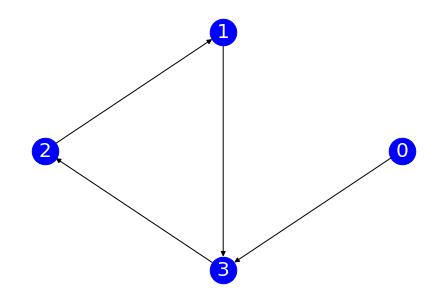

T2: a canonical weak tournament for 3 candidates: 


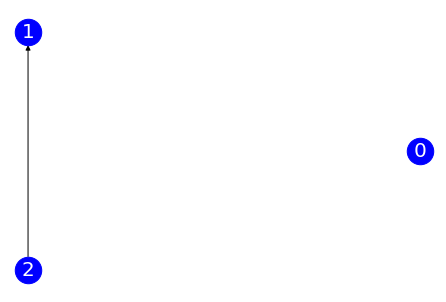

All the isomorphisms between the weak tournament T2 with 3 candidates and subgraphs of the weak tournament T1 with 4 candidates:

e(0) = 0, e(1) = 1, e(2) = 2
	This mapping is a tournament embedding

e(0) = 0, e(1) = 2, e(2) = 3
	There is an edge from 0 to 3 in T1
	But no edge from  0 to 2 in T2
	So this mapping is not a tournament embedding of T2 into T1

e(0) = 0, e(1) = 3, e(2) = 1
	There is an edge from 0 to 3 in T1
	But no edge from  0 to 1 in T2
	So this mapping is not a tournament embedding of T2 into T1

e(0) = 1, e(1) = 3, e(2) = 0
	There is an edge from 1 to 3 in T1
	But no edge from  0 to 1 in T2
	So this mapping is not a tournament embedding of T2 into T1



In [8]:
T1 = canonical_weak_tournaments[4][20]

print("T1: a canonical weak tournament for 4 candidates: ")
display_wt(T1)

print("T2: a canonical weak tournament for 3 candidates: ")
T2 = canonical_weak_tournaments[3][1]
display_wt(T2)

print("All the isomorphisms between the weak tournament T2 with 3 candidates and subgraphs of the weak tournament T1 with 4 candidates:\n")
for iso in nx.algorithms.isomorphism.GraphMatcher(T1, T2).subgraph_isomorphisms_iter():
    
    # iso is a dictionary mapping a subset of elements of the bigger graph T1 to the 
    # small graph T2, but it is easier to think about the inverse function mapping 
    # nodes in the small graph T2 into the bigger graph T1. 
    inverse_iso = {v:k for k,v in iso.items()}
    
    print(", ".join([f"e({c1}) = {c2}" for c1, c2 in inverse_iso.items()]))
    
    is_embedding = True
    for c1, c2 in product(T2.nodes, T2.nodes): 
        if T1.has_edge(inverse_iso[c1],inverse_iso[c2]) and not T2.has_edge(c1,c2):
            print(f"\tThere is an edge from {inverse_iso[c1]} to {inverse_iso[c2]} in T1")
            print(f"\tBut no edge from  {c1} to {c2} in T2")
            print("\tSo this mapping is not a tournament embedding of T2 into T1\n")
            is_embedding=False
    
    if is_embedding: 
        print("\tThis mapping is a tournament embedding\n")

### B. Generate canonical tournament embeddings

To deal with the above  issue, we define a function which checks if a Networkx subgraph isomorphism is indeed a tournament embedding.

In [9]:
def is_embedding(small_g, big_g, iso):
    """
    iso is an isomorphism from small_g to a subgraph of big_g,
    but we must check whether iso is an embedding. 
    returns True if iso is an embedding of small_g into big_g. 
    
    Returns True if for every pair of candidates c1 and c2 in small_g, 
    if there is an edge between iso[c1] and iso[c2] in big_g, then 
    there is an edge between c1 and c2 in small_g
    """
    for c1, c2 in product(small_g.nodes, small_g.nodes): 
        if big_g.has_edge(iso[c1],iso[c2]) and not small_g.has_edge(c1,c2):
            return False
    return True    

Find all canonical tournament embeddings from canonical weak tournaments of size $n$ into canonical weak tournaments of size $n+1$. 

In [10]:
def find_embeddings(min_num_cands, max_num_cands, canonical_graphs):
    """
    find embeddings of graphs in 'canonical_graphs',
    embeddings of n-tournaments to (n+1)-tournaments, for n=min_num_cands,...,max_num_cands-1
    """
    embeddings = list()

    for nc in range(min_num_cands, max_num_cands): 
        # for each number of candidate between min_num_cands and max_num_cands - 1  

        for g1 in canonical_graphs[nc]: 
            # for each canonical graph of size nc    

            for g2 in canonical_graphs[nc+1]:
                # for each canonical graph of size nc+1

                seen_ranges = set()

                for iso in nx.algorithms.isomorphism.GraphMatcher(g2, g1).subgraph_isomorphisms_iter():
                    # for each isomporphism from g1 to a subgraph of g2

                    # NOTE: iso is a dictionary associating a subset of nodes from g2 to the nodes in g1
                    # It's easier to think about the isomorphism as a mapping from the smaller graph g1 
                    # into the bigger graph g2:
                    inverse_iso = {v:k for k,v in iso.items()}

                    rng = tuple(sorted(iso.keys())) # the range of the isomorphism (nodes in the bigger graph)
                    if not rng in seen_ranges and is_embedding(g1, g2, inverse_iso): 
                        # if haven't seen the range yet and g1 is an embedding into g2
                        seen_ranges.add(rng)
                        # record the smaller graph g1, larger graph g2 and isomorphism from g1 to g2
                        embeddings.append((g1, g2, inverse_iso))  
    return embeddings

## 4. Binary $\gamma$

In [11]:
def generate_bg_formula(min_num_cands,
                        max_num_cands, 
                        canonical_graphs,
                        wt_dictionary, 
                        embeddings, 
                        two_cand_tournament
                       ): 
    """
    returns CNF clauses expressing binary gamma
    """
    

    maj_winner = [c for c in two_cand_tournament.nodes if two_cand_tournament.out_degree(c) == 1]
    non_maj_winner = [c for c in two_cand_tournament.nodes if c not in maj_winner]
    
    can_2_maj_pref_cand_literal = wt_dictionary[(two_cand_tournament, tuple(maj_winner))]
    can_2_min_pref_cand_literal = wt_dictionary[(two_cand_tournament, tuple(non_maj_winner))]
    
    C_bg = list()

    for nc in range(min_num_cands, max_num_cands + 1):
        for t1 in canonical_graphs[nc]:
            # for each canonical graph for nc candidates
            for emb in [_emb for _emb in embeddings if _emb[0] == t1]: 
                # for each possible embedding from t1 into a canonical graph emb[1]
                
                t2 = emb[1]
                # t2 is a canonical graph on nc+1 candidates, which t1 embeds into
                
                new_cand = list(set(emb[1].nodes).difference(set(emb[2].values())))[0]
                # new_cand is the candidate in t2 not in the range of the embedding from t1 to t2
                
                for cand in t1.nodes:
                    cand_t2 = emb[2][cand]
                    
                    if (cand_t2, new_cand) in t2.edges: # if cand_t2 is majority preferred to new_cand
                        for ws in [_ws for _ws in powerset_ne_plus(t1.nodes, [cand]) if (t1, tuple(_ws)) in wt_dictionary]:
                            # for winning sets in t1 including cand (i.e. if cand (pre-image of cand_t2) is a winner in t1)
                            clause = [-wt_dictionary[(t1, tuple(ws))],
                                     -can_2_maj_pref_cand_literal]  
                            # if majority preference holds on the two-candidate tournament
                            clause += [wt_dictionary[(t2, tuple(_ws))] \
                                       for _ws in powerset_ne_plus(t2.nodes, [cand_t2]) \
                                       if (t2, tuple(_ws)) in wt_dictionary]
                            # then cand_t2 is a winner in t2
                            
                            C_bg.append(clause)
                        
                    elif (new_cand, cand_t2) in t2.edges: # if cand_t2 is minority preferred to new_cand
                        for ws in [_ws for _ws in powerset_ne_plus(t1.nodes, [cand]) if (t1, tuple(_ws)) in wt_dictionary]:
                            # for winning sets in t1 including cand (i.e. if cand (pre-image of cand_t2) is a winner in t1)
                            clause = [-wt_dictionary[(t1, tuple(ws))],
                                     -can_2_min_pref_cand_literal]
                            # if minority preference holds on the two-candidate tournament
                            clause += [wt_dictionary[(t2, tuple(_ws))] \
                                       for _ws in powerset_ne_plus(t2.nodes, [cand_t2]) \
                                       if (t2, tuple(_ws)) in wt_dictionary]
                            # then cand_t2 is a winner in t2
                            
                            C_bg.append(clause)
                        
            
    return C_bg


## 5. $\alpha$-resoluteness

In [12]:
def generate_ar_formula(min_num_cands, 
                        max_num_cands, 
                        canonical_graphs, 
                        wt_dictionary, 
                        embeddings, 
                        two_cand_tournament
                       ): 
    """
    returns CNF clauses expressing binary alpha
    """
    
    maj_winner = [c for c in two_cand_tournament.nodes if two_cand_tournament.out_degree(c) == 1]
    non_maj_winner = [c for c in two_cand_tournament.nodes if c not in maj_winner]
    
    can_2_maj_pref_cand_literal = wt_dictionary[(two_cand_tournament, tuple(maj_winner))]
    can_2_min_pref_cand_literal = wt_dictionary[(two_cand_tournament, tuple(non_maj_winner))]
    
    C_ar = list()

    for nc in range(min_num_cands, max_num_cands + 1):

        for t1 in canonical_graphs[nc]:
            # for each canonical graph for nc candidates
            
            for emb in [_emb for _emb in embeddings if _emb[0] == t1]: 
                # for each possible embedding from t1 into a canonical graph emb[1]
                
                t2 = emb[1]
                # t2 is a canonical graph on nc+1 candidates, which t1 embeds into
                
                new_cand = list(set(emb[1].nodes).difference(set(emb[2].values())))[0]
                # new_cand is the candidate in t2 not in the range of the embedding from t1 to t2
                
                for cand in t1.nodes:
                    cand_t2 = emb[2][cand]
                    
                    if (cand_t2, new_cand) in t2.edges: # if cand_t2 is majority preferred to new_cand
                        for ws in [_ws for _ws in powerset_ne_plus(t1.nodes, [cand]) if (t1, tuple(_ws)) in wt_dictionary]:
                            clause = [-wt_dictionary[(t1, tuple(ws))],
                                     -can_2_maj_pref_cand_literal]       
                            # if cand (pre-image of cand_t2) is a winner in t1 AND
                            # if majority preference holds on the two-candidate tournament
                            
                            clause += [wt_dictionary[(t2, tuple(_ws))] \
                                        for _ws in powerset_ne(t2.nodes) \
                                        if (t2, tuple(_ws)) in wt_dictionary and len(_ws) <= len(ws)]
                            # then winning set in t2 cannot contain any new candidates
                            
                            C_ar.append(clause)
                            
                        
                    elif (new_cand, cand_t2) in t2.edges: # if cand_t2 is minority preferred to new_cand
                        for ws in [_ws for _ws in powerset_ne_plus(t1.nodes, [cand]) if (t1, tuple(_ws)) in wt_dictionary]:
                            clause = [-wt_dictionary[(t1, tuple(ws))],
                                     -can_2_min_pref_cand_literal]
                            # if cand (pre-image of cand_t2) is a winner in t1 AND
                            # if minority preference holds on the two-candidate tournament
                            
                            clause += [wt_dictionary[(t2, tuple(_ws))] \
                                        for _ws in powerset_ne(t2.nodes) \
                                        if (t2, tuple(_ws)) in wt_dictionary and len(_ws) <= len(ws)]
                            # then winning set in t2 cannot contain any new candidates
                            
                            C_ar.append(clause)
                        
    return C_ar


## 6. Binary quasi-resoluteness

In [13]:
def generate_binary_qr_formula(canonical_graphs, wt_dictionary):
    
    C_bqr = list()
    
    for g in canonical_graphs[2]:
        
        if is_tournament(g):
            clause = []

            for pw in [_ws for _g, _ws in wt_dictionary.keys() if _g == g]:
                if len(pw) == 1:
                    clause += [wt_dictionary[(g, pw)]]

            C_bqr.append(clause)
        
    return C_bqr

## 7. Demonstration of Proposition A.12.1


In [14]:
min_num_cands, max_num_cands = 2, 5

canonical_graphs = canonical_weak_tournaments

graphs = [wt for nc in range(min_num_cands, max_num_cands + 1) for wt in  canonical_graphs[nc]]

possible_winners = find_possible_winners(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the possible winners.")

wt_dictionary = generate_wt_dictionary(possible_winners)
print("Done creating the encoding.")

C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.")

embeddings = find_embeddings(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the embeddings.")

Done finding the possible winners.
Done creating the encoding.
Done creating the function formula.
Done finding the embeddings.


In [15]:
two_cand_tournament = canonical_weak_tournaments[2][1]
print("Two candidate tournament ", two_cand_tournament.edges)

C_bg = generate_bg_formula(min_num_cands, 
                           max_num_cands, 
                           canonical_graphs, 
                           wt_dictionary, 
                           embeddings,
                           two_cand_tournament
                          )
print("Done creating the BG formula.")

C_ar = generate_ar_formula(min_num_cands,
                           max_num_cands,
                           canonical_graphs, 
                           wt_dictionary, 
                           embeddings,
                           two_cand_tournament)
print("Done creating the AR formula.")

C_bqr = generate_binary_qr_formula(canonical_graphs, wt_dictionary)
print("Done creating BQR formula")

Two candidate tournament  [(1, 0)]
Done creating the BG formula.
Done creating the AR formula.
Done creating BQR formula


In [16]:
formula =  C_func + C_bg + C_ar + C_bqr
sat_solver = Glucose3()
for cl in formula:
    sat_solver.add_clause(cl)

if sat_solver.solve(): 
    print(f"There is a canonical weak tournament solution up to {max_num_cands} candidates that satisfies the orbit condition, BG, AR, and BQR.")
else: 
    print(f"There is no canonical weak tournament solution up to {max_num_cands} candidates that satisfies the orbit condition, BG, AR, and BQR.")

# uncomment to see the model (list of literals that are true)
#print(sat_solver.get_model())
vm = sat_solver.get_model()

There is a canonical weak tournament solution up to 5 candidates that satisfies the orbit condition, BG, AR, and BQR.


## 8. Demonstration of Proposition A.12.2


In [17]:
min_num_cands, max_num_cands = 2, 6

canonical_graphs = canonical_tournaments

graphs = [wt for nc in range(min_num_cands, max_num_cands + 1) for wt in  canonical_graphs[nc]]

possible_winners = find_possible_winners(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the possible winners.")

wt_dictionary = generate_wt_dictionary(possible_winners)
print("Done creating the encoding.")

C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.")

embeddings = find_embeddings(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the embeddings.")

Done finding the possible winners.
Done creating the encoding.
Done creating the function formula.
Done finding the embeddings.


In [18]:
two_cand_tournament = canonical_tournaments[2][0]
print("Two candidate tournament ", two_cand_tournament.edges)

C_bg = generate_bg_formula(min_num_cands, 
                           max_num_cands, 
                           canonical_graphs, 
                           wt_dictionary, 
                           embeddings,
                           two_cand_tournament
                          )
print("Done creating the BG formula.")

C_ar = generate_ar_formula(min_num_cands,
                           max_num_cands,
                           canonical_graphs, 
                           wt_dictionary, 
                           embeddings,
                           two_cand_tournament)
print("Done creating the AR formula.")

C_bqr = generate_binary_qr_formula(canonical_graphs, wt_dictionary)
print("Done creating BQR formula")

Two candidate tournament  [(1, 0)]
Done creating the BG formula.
Done creating the AR formula.
Done creating BQR formula


In [19]:
formula = C_func + C_bg + C_ar + C_bqr
sat_solver = Glucose3()
for cl in formula:
    sat_solver.add_clause(cl)

if sat_solver.solve(): 
    print(f"There is a canonical weak tournament solution up to {max_num_cands} candidates that satisfies the orbit condition, BG, AR, and BQR.")
else: 
    print(f"There is no canonical weak tournament solution up to {max_num_cands} candidates that satisfies the orbit condition, BG, AR, and BQR.")

# uncomment to see the model (list of literals that are true)
#print(sat_solver.get_model())


There is no canonical weak tournament solution up to 6 candidates that satisfies the orbit condition, BG, AR, and BQR.


## 9. Minimal set of tournaments to prove Proposition A.12.2 (assuming binary majoritarianism)

It turns out that not all of the canonical tournaments used above are needed for the unsatisfiability result.   Below, we load a minimal sets of canonical tournaments that suffice for the unsatisfiability, extracted from an MUS provided by PicoMUS.   By *minimal* we mean that removing any tournament from the set results in a satisfiability result.  

To prove Proposition A.12.2, it suffices to prove it under the additional assuming of *binary majoritarianism* (BM) which states that in the two candidate canonical tournament, the majority winner is the unique winner. See Section A.5. 


The following tournaments is a minimal set tournaments needed to prove Proposition A.12.2


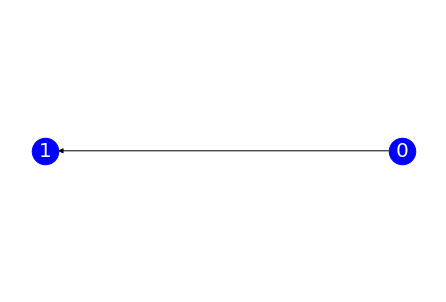

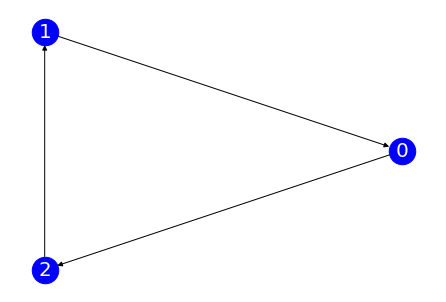

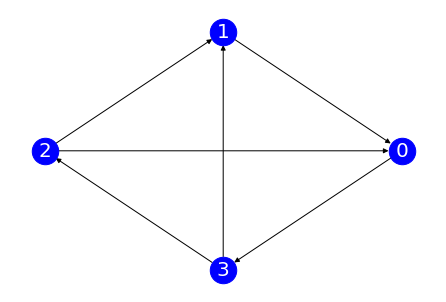

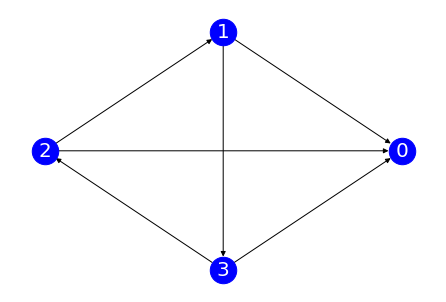

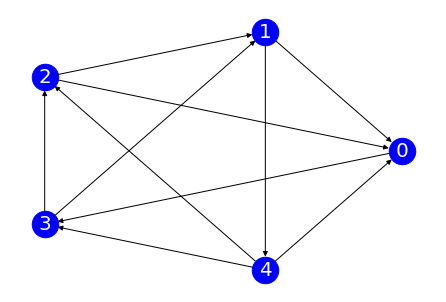

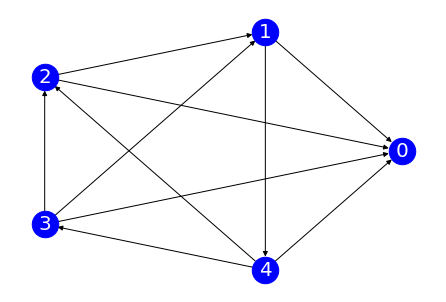

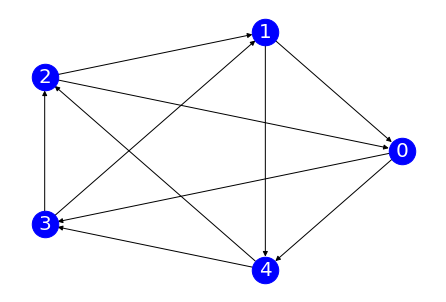

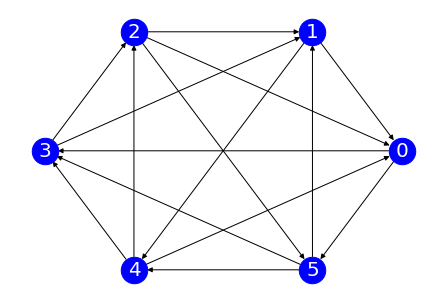

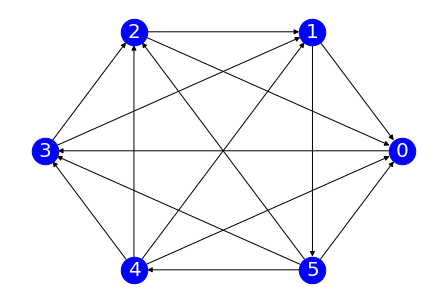

In [20]:
all_gs_mus_dict_majoratarian = pickle.load(open("./graphs_for_impossibilities/all_gs_mus_dict_majoritarian.pkl", "rb"))

print(f"\nThe following tournaments is a minimal set tournaments needed to prove Proposition A.12.2")
for nc in range(2, 7): 
    for wt in all_gs_mus_dict_majoratarian[nc]: 
        display_wt(wt)

In [21]:
min_num_cands, max_num_cands = 2, 6

canonical_graphs = all_gs_mus_dict_majoratarian

graphs = [wt for nc in range(min_num_cands, max_num_cands + 1) for wt in  canonical_graphs[nc]]

possible_winners = find_possible_winners(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the possible winners.")

wt_dictionary = generate_wt_dictionary(possible_winners)
print("Done creating the encoding.")

C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.")

embeddings = find_embeddings(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the embeddings.")

Done finding the possible winners.
Done creating the encoding.
Done creating the function formula.
Done finding the embeddings.


In [22]:
two_cand_tournament = canonical_graphs[2][0]
print("Two candidate tournament ", two_cand_tournament.edges)

C_bg = generate_bg_formula(min_num_cands, 
                           max_num_cands, 
                           canonical_graphs, 
                           wt_dictionary, 
                           embeddings,
                           two_cand_tournament
                          )
print("Done creating the BG formula.")

C_ar = generate_ar_formula(min_num_cands,
                           max_num_cands,
                           canonical_graphs, 
                           wt_dictionary, 
                           embeddings,
                           two_cand_tournament)
print("Done creating the AR formula.")

C_bqr = generate_binary_qr_formula(canonical_graphs, wt_dictionary)
print("Done creating BQR formula")

C_bm = [[1]]
print("Done creating BM formula")

Two candidate tournament  [(0, 1)]
Done creating the BG formula.
Done creating the AR formula.
Done creating BQR formula
Done creating BM formula


In [23]:
formula = C_func + C_bg + C_ar + C_bqr + C_bm

sat_solver = Glucose3()
for cl in formula:
    sat_solver.add_clause(cl)

if sat_solver.solve(): 
    print(f"There is a canonical weak tournament solution up to {max_num_cands} candidates that satisfies the orbit condition, BG, AR, BQR, and BM.")
else: 
    print(f"There is no canonical weak tournament solution up to {max_num_cands} candidates that satisfies the orbit condition, BG, AR, BQR, and BM.")

# uncomment to see the model (list of literals that are true)
#print(sat_solver.get_model())


There is no canonical weak tournament solution up to 6 candidates that satisfies the orbit condition, BG, AR, BQR, and BM.


## 10. Demonstration of Remark 2.9.3

In [24]:
min_num_cands, max_num_cands = 2, 6

# Paths to pickled weak tournaments
canonical_weak_tournament_paths = {
    2: 'weak_tourns/weak_tourns_2.pkl',
    3: 'weak_tourns/weak_tourns_3.pkl',
    4: 'weak_tourns/weak_tourns_4.pkl',
    5: 'weak_tourns/weak_tourns_5.pkl',
    6: 'weak_tourns/weak_tourns_6.pkl',
#    7: 'weak_tourns/weak_tourns_7.pkl',
}

# Load all the canonical tournaments
canonical_weak_tournaments = {nc: pickle.load(open(canonical_weak_tournament_paths[nc], 'rb'))
                              for nc in range(min_num_cands, max_num_cands+1)}


In [25]:
%%time 

# Warning: This takes a long time to run. 

canonical_graphs = canonical_weak_tournaments

graphs = [wt for nc in range(min_num_cands, max_num_cands + 1) for wt in  canonical_graphs[nc]]

possible_winners = find_possible_winners(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the possible winners.")

wt_dictionary = generate_wt_dictionary(possible_winners)
print("Done creating the encoding.")

C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.")

embeddings = find_embeddings(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the embeddings.")

Done finding the possible winners.
Done creating the encoding.
Done creating the function formula.
Done finding the embeddings.
CPU times: user 3h 18min 50s, sys: 44.5 s, total: 3h 19min 35s
Wall time: 3h 20min 12s


In [28]:
%%time 

two_cand_tournament = canonical_weak_tournaments[2][1]
print("Two candidate tournament ", two_cand_tournament.edges)

C_ar = generate_ar_formula(min_num_cands,
                           max_num_cands,
                           canonical_graphs, 
                           wt_dictionary, 
                           embeddings,
                           two_cand_tournament)
print("Done creating the AR formula.")

C_bqr = generate_binary_qr_formula(canonical_graphs, wt_dictionary)
print("Done creating BQR formula")

Two candidate tournament  [(1, 0)]
Done creating the AR formula.
Done creating BQR formula
CPU times: user 29min 17s, sys: 10.6 s, total: 29min 27s
Wall time: 29min 33s


In [29]:
formula = C_func + C_ar + C_bqr
sat_solver = Glucose3()
for cl in formula:
    sat_solver.add_clause(cl)

if sat_solver.solve(): 
    print(f"There is a canonical weak tournament solution up to {max_num_cands} candidates that satisfies the orbit condition, AR, and BQR.")
else: 
    print(f"There is no canonical weak tournament solution up to {max_num_cands} candidates that satisfies the orbit condition, AR, and BQR.")

# uncomment to see the model (list of literals that are true)
#print(sat_solver.get_model())


There is a canonical weak tournament solution up to 6 candidates that satisfies the orbit condition, AR, and BQR.
